<a href="https://colab.research.google.com/github/kleofas97/Biometrics/blob/main/lab/IrisiRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
from typing import List
from skimage.filters import gabor_kernel
import itertools
from scipy import ndimage as ndi

In [ ]:
def findPupil(img,show=False):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(gray,T,255,cv2.THRESH_BINARY)
  if show:
    f, axarr = plt.subplots(2,3)
    axarr[0,0].imshow(thresh, 'gray',vmin=0,vmax=255) #add subplot

  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
  res = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel)
  kernel = np.ones((3,3),np.uint8)
  dilate = cv2.dilate(res, kernel)
  dilate = cv2.dilate(dilate, kernel)
  if show:
    axarr[0,1].imshow(dilate, 'gray') #add subplot

  im_floodfill = dilate.copy()
  h, w = dilate.shape[:2]
  mask = np.zeros((h+2, w+2), np.uint8)

  # Floodfill from point (0, 0)
  cv2.floodFill(im_floodfill, mask, (0,0), 255);

  # Invert and dilate floodfilled image
  im_floodfill_inv = cv2.bitwise_not(im_floodfill)
  im_floodfill_inv = cv2.dilate(im_floodfill_inv, kernel)
  if show:  
    axarr[0,2].imshow(im_floodfill_inv, 'gray',vmin=0,vmax=255) #add subplot
  

  connectivity = 8 
  output = cv2.connectedComponentsWithStats(im_floodfill_inv, connectivity, cv2.CV_32S)
  (numLabels, labels, stats, centroids) = output
  for i in range(0, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    out = gray.copy()
    if show:
      cv2.rectangle(out, (x, y), (x + w, y + h), (0, 255, 255), 3)
      cv2.circle(out, (int(cX), int(cY)), 4, (0, 255, 255), -1)
  if show:
    axarr[1,0].imshow(out, 'gray') #add subplot

  mask = im_floodfill_inv
  I = (gray*(mask/255.0) + 65*(mask/255.0))
  I = np.array(255*I, dtype = 'uint8')
  I = cv2.medianBlur(I,5) #add subplot
  if show:
    axarr[1,1].imshow(I, 'gray')
    f.subplots_adjust(hspace=0.3)
    plt.axis('off')
    plt.show()
  return I, (cX,cY)


In [ ]:
def max_intense(r_intenses: List) -> List:
    """
    Calculate the max diff and its r
      :params
      r_intenses = [[r,meanIntense],[r,meanIntense].....]
      out = [r,max_difference,r2_max,max2_difference]
    """
    intenses = [r_intense[1] for r_intense in r_intenses]
    rs = [r_intense[0] for r_intense in r_intenses]
    differences = [np.abs(s - t) for s, t in zip(intenses, intenses[1:])]
    diff_for_r = differences.copy()
    differences.sort(reverse=True)
    max_diff = differences[0]
    second_max_diff = differences[1]
    top_2_r = np.argsort(diff_for_r)
    max_r = rs[top_2_r[-1]]
    second_max_r = rs[top_2_r[-2]]
    return [max_r,max_diff,second_max_r,second_max_diff ]
def iris_coord(max_intense_xy: List)-> (int,int,int,int):
    """
    find the max mean intense for different x and y point, and return the x,y,r values
    """
    intenses = [r_intense[2][1] for r_intense in max_intense_xy]
    x,y,r_intence = max_intense_xy[np.argmax(intenses)]
    r,_,r2,_ = r_intence
    return x,y,r,r2

In [ ]:
def exploding_circles(img,cX,cY,startRadius = 50,stepRadius=10,finishRadius=270,startAngle=0,stepAngle=5,finishAngle=360):
  
  cX = int(cX)
  cY = int(cY)

  intense = []
  max_intense_xy = []
  currentIntense  = 0
  meanIntense = 0
  i = 0 
  img_circles = img.copy()
  #two loops over  the 3x3 grid 
  for x in range(cX-1,cX+2):
    for y in range(cY-1,cY+2):
      for r in range(startRadius, finishRadius, stepRadius):
        # cv2.circle(img_circles, (x, y), r, (255, 255, 255), 1)
        for a in range(startAngle, finishAngle, stepAngle):
          pX = x + r*math.cos(math.radians(a))
          pY = y + r*math.sin(math.radians(a))
          if pX > 0 and pY < img.shape[0] and pY > 0 and pX < img.shape[1]:
            currentIntense += gray[int(pY), int(pX)]
            i+=1
        meanIntense = currentIntense / i
        i = 0
        intense.append([r, meanIntense])
        currentIntense = 0
      max_intense_xy.append([x,y,max_intense(intense)])
      intense.clear()
  x,y,r,r2 = iris_coord(max_intense_xy)
  # cv2.circle(img_circles, (x, y), r, (255, 255, 255), 2)
  # cv2.circle(img_circles, (x, y), r2, (255, 255, 255), 2)
  # plt.imshow(img_circles, 'gray',vmin=0,vmax=255)
  return x,y,r,r2

In [ ]:
def get_gabor(img: np.array, x: int, y: int, kernels: list) -> list:
    """
    Calculates the Gabor filter response for the given image.
    :param img: Source image
    :param x: Center point X coordinate
    :param y: Center point Y coordinate
    :param kernels: List of Gabor kernels
    :return: Binary code
    """
    selection = img[y-10:y+11, x-10:x+11]
    real_list = []
    imag_list = []
    bits = []
    for ker in kernels:
        filtered_real = ndi.convolve(selection, np.real(ker), mode='wrap')
        filtered_imag = ndi.convolve(selection, np.imag(ker), mode='wrap')
        real_list.append(filtered_real)
        imag_list.append(filtered_imag)

    for i in range(len(real_list)):
        real_sum = 0
        imag_sum = 0
        for row in range(len(real_list[i])):
            for col in range(len(real_list[i][0])):
                real_sum += 1 if real_list[i][row, col] >= 0 else -1
                imag_sum += 1 if imag_list[i][row, col] != 0 else -1
        bits.append((1 if real_sum >= 0 else 0, 1 if imag_sum >= 0 else 0))
    return bits

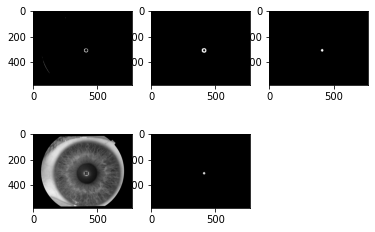

In [ ]:
path_to_zip = "/content/iris_database_train.zip"
train_dataset_dir = "/content/sample_data/iris_train"

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(train_dataset_dir)

path_to_zip = "/content/iris_database_test.zip"
test_dataset_dir = "/content/sample_data/iris_test"

with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(test_dataset_dir)


img = cv2.imread(train_dataset_dir + "/" +  'iris_database_train/irisC_2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
T= 249
I, centerCoord = findPupil(img)

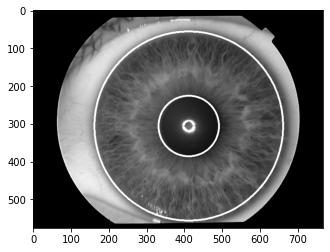

In [ ]:
cX, cY = centerCoord
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
x,y,r,r2 = exploding_circles(gray,cX,cY)
img_circles = gray.copy()
cv2.circle(img_circles, (x, y), r, (255, 123, 255), 3)
cv2.circle(img_circles, (x, y), r2, (255, 123, 255), 3)
plt.imshow(img_circles, 'gray',vmin=0,vmax=255)

In [ ]:
def image_to_code(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_color = cv2.imread(path)
    I, centerCoord = findPupil(img_color)
    cX, cY = centerCoord
    x,y,r,r2 = exploding_circles(gray,cX,cY)
    kernels = []
    sigma = 2
    for theta in range(8):
            t = theta / 8. * np.pi
            kernel = gabor_kernel(0.15, theta, sigma_x=sigma, sigma_y=sigma)
            kernels.append(kernel)

        # Create radiuses list
    radiuses = np.linspace(r2+20, r, 8, dtype=int)
    binary_code = []

    for r in radiuses:
            # Iterate over angle loops for both sides
            for angle in itertools.chain(range(45, -45, 12), range(225, 135, -12)):
                xc = int(cX) + int(r * np.cos(angle / 180))
                yc = int(cY) + int(r * np.sin(angle / 180))
                binary_code.append(get_gabor(gray, xc, yc, kernels))

        # Convert the binary code to a list of tuples
    binary_code = list(itertools.chain.from_iterable(binary_code))
    return binary_code

In [ ]:
# Similarity calculation
def hamming_distance(code_A: list, code_B: list) -> float:
    """
    Calculates a Hamming distance between the two encoded images.
    :param code_A: First image to compare
    :param code_B: Second image to compare
    :return: Similarity factor
    """
    diffs = 0
    for a, b in zip(code_A, code_B):
        for in_a, in_b in zip(a, b):
            # Double iteration, since there are two bits
            diffs += 1 if in_a != in_b else 0

    return (len(code_A) - diffs) / len(code_A) * 100

In [ ]:
dataset_dir = '/content/sample_data/iris_train/iris_database_train'
dataset = []
for img_path in os.listdir(dataset_dir):
      dataset.append((img_path[:5], image_to_code(os.path.join(dataset_dir, img_path))))

# Set the detection threshold:
det_thresh = 82
img_path = '/content/sample_data/iris_test/iris_database_test/irisA_3.png'

classified = False
test_code = image_to_code(img_path)
similarity_array = []

for pair in dataset:
    similarity_array.append(hamming_distance(pair[1], test_code))

test_thresh = max(similarity_array)
max_idx = similarity_array.index(max(similarity_array))
if test_thresh > det_thresh:
  print(f"The image {img_path[-11:-6]} is a part of {dataset[max_idx][0]} class with a {test_thresh:.2f}% similarity factor.")
  classified = True

if not classified:
    print(f"The image {img_path[-11:-6]} is out of the database.")

The image irisA is a part of irisA class with a 100.00% similarity factor.


# To samo co wyżej tylko w wersji testowej - do usunięcia - na razie niech zostanie

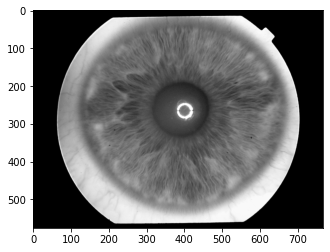

In [ ]:
img = cv2.imread(train_dataset_dir + "/" +  'iris_database_train/irisA_1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, 'gray',vmin=0,vmax=255)

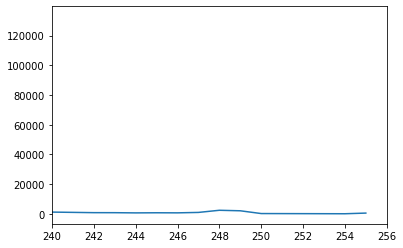

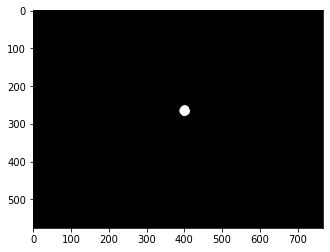

2


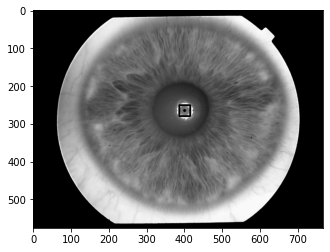

In [ ]:
connectivity = 8 
output = cv2.connectedComponentsWithStats(im_floodfill_inv, connectivity, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
(numLabels, labels, stats, centroids) = output
print(numLabels)
for i in range(0, numLabels):
  x = stats[i, cv2.CC_STAT_LEFT]
  y = stats[i, cv2.CC_STAT_TOP]
  w = stats[i, cv2.CC_STAT_WIDTH]
  h = stats[i, cv2.CC_STAT_HEIGHT]
  area = stats[i, cv2.CC_STAT_AREA]
  (cX, cY) = centroids[i]
  out = gray.copy()
  cv2.rectangle(out, (x, y), (x + w, y + h), (0, 255, 255), 3)
  cv2.circle(out, (int(cX), int(cY)), 4, (0, 255, 255), -1)

plt.imshow(out, 'gray')

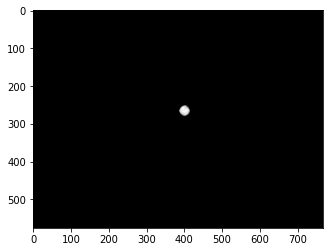

In [ ]:
mask = im_floodfill_inv
I = (gray*(mask/255.0) + 65*(mask/255.0))
I = np.array(255*I, dtype = 'uint8')
I = cv2.medianBlur(I,5)
plt.imshow(I, 'gray')